## Evaluación de Predicción de Delitos Seguimiento

Coder: Lenin G. F.
Fecha: 2023-09-10

## Objetivo:

* Realizar la medición del desempeño del clasificador sobre el dataset completo 2014 - 2023


## Restricciones o Problemas latentes

1. El tipo penal definido por comisión no es el mismo registrado en SIAF de acuerdo a la fecha de corte del 30 de septiembre de 2023.

2. Es más adecuado utilizar el tipo penal SIAF por cuanto desde el 2014 se debieron realizar investigaciones y otras operaciones fiscales que son las que pudieron determinar el tipo penal final de la ndd

3. No se puede comparar la totalidad de resultados del modelo con la totalidad de valores registrados en comisión debido a que no se dispone de la totalidad de relatos siaf

## Recursos

Se utiliza el registro sql en reportes.robos_2014_08012023_predicted como fuente primaria de datos

In [2]:
import pandas as pd
from src.utils import conectar_sql

conx = conectar_sql()
query = "select * from reportes.robos_2014_08012023_predicted robos"

df = pd.read_sql(query,conx)
df.shape


conectando con big data database....


(734506, 14)

La predicción realizada se realizó para el tipo penal Robo registrado en Comisión. Sin embargo, esto puede ser no correcto por cuanto a la *fecha de corte* del 30 de septiembre de 2023, la tipificación SIAF es diferente. Es posible que sea recomendable que la predicción se realice sobre el tipo penal definido por Fiscalía

In [3]:
df.columns

Index(['NDD', 'Tipo_Delito_PJ_comision', 'delitos_seguimiento_comision',
       'delitos_validados_comision', 'gen_delito_tipopenal',
       'gen_delito_numart', 'Fecha_Registro', 'FECHA_PS', 'FechaCorte',
       'RELATO_SIAF', 'd_CANTIDAD_PALABRAS', 'delitos_seguimiento_predicted',
       'delitos_seguimiento_predicted_SCORE',
       'FechaActualizacionDelitosSeguimiento'],
      dtype='object')

In [4]:
df.groupby(['Tipo_Delito_PJ_comision', 'gen_delito_tipopenal'])['NDD'].count()

Tipo_Delito_PJ_comision  gen_delito_tipopenal                                                
ROBO                     ABIGEATO                                                                     7
                         ABUSO DE CONFIANZA                                                          60
                         ABUSO DE FACULTADES                                                          1
                         ABUSO SEXUAL                                                                 2
                         ACCIDENTE DE TRANSITO CON SOLO LESIONES INDETERMINADOS.                      2
                         ACTOS DE ODIO                                                                1
                         APROPIACIÓN FRAUDULENTA POR MEDIOS ELECTRÓNICOS                              1
                         ARMAS DE FUEGO, MUNICIONES Y EXPLOSIVOS NO AUTORIZADOS                       1
                         ASESINATO                                        

En consecuencia, en cuanto al tipo penal, Si bien la comsión contemplaría el dataset completo, considerando el tipo penal del siaf, sólo existiría coincidencia en 99.86%. En este sentido, *no se incurre en error alguno al despreciar los casos en que el tipo penal entre fiscalía y comisión divergen*

In [7]:
df[df.gen_delito_tipopenal=="ROBO"].shape

(733483, 14)

In [8]:
df[df.gen_delito_tipopenal=="ROBO"].shape[0]/df.shape[0]*100

99.86072271703704

## Cantidad de palabras en relato

Se debería revisar la cantidad de palabras del relato por tipo penal SIAF

Text(0.5, 1.0, 'Histograma de Cantidad de Palabras Comision')

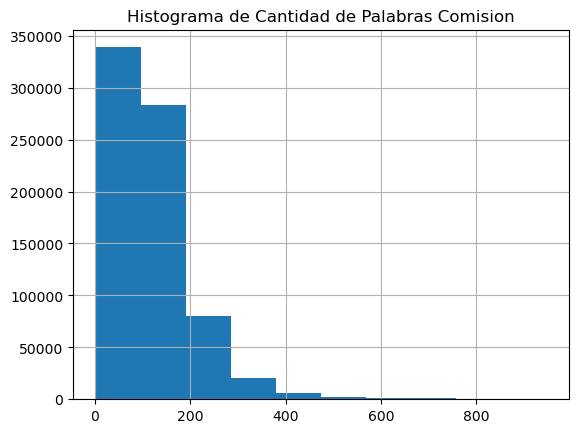

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

df.d_CANTIDAD_PALABRAS.hist().plot()
plt.title('Histograma de Cantidad de Palabras Comision')

Text(0.5, 1.0, 'Histograma de Cantidad de Palabras Robo-SIAF')

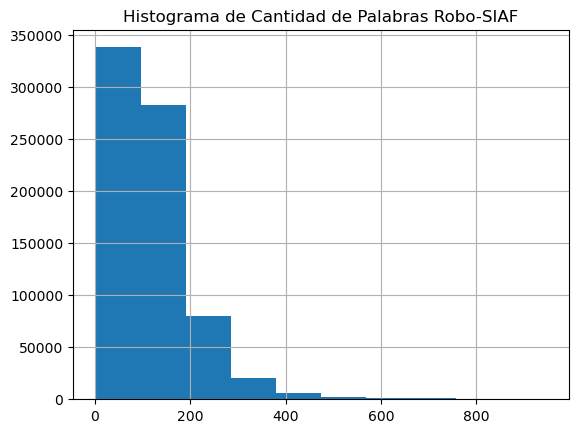

In [9]:
df[df.gen_delito_tipopenal=="ROBO"].d_CANTIDAD_PALABRAS.hist().plot()
plt.title('Histograma de Cantidad de Palabras Robo-SIAF')

Con el diagrama de caja se puede evaluar la distribución de la cantidad de palabras

Text(0.5, 1.0, 'DIAGRAMA DE CAJA DE CANTIDAD DE PALABRAS EN RELATO EN DATASET COMISION')

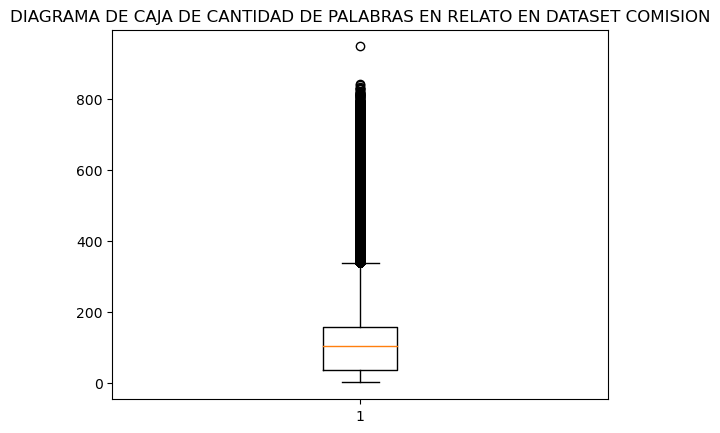

In [10]:
plt.boxplot(df.d_CANTIDAD_PALABRAS)
plt.title('DIAGRAMA DE CAJA DE CANTIDAD DE PALABRAS EN RELATO EN DATASET COMISION')

Estadísticamente los relatos tienen la siguiente característica

In [11]:
df.d_CANTIDAD_PALABRAS.describe()

count    734506.000000
mean        113.166050
std          92.107162
min           1.000000
25%          36.000000
50%         103.000000
75%         157.000000
max         947.000000
Name: d_CANTIDAD_PALABRAS, dtype: float64

La cantidad de relatos nulos o vacíos es

In [12]:
df.RELATO_SIAF.isna().sum(), df[df.d_CANTIDAD_PALABRAS==0].shape

(0, (0, 14))

La cantidad de relatos con cantidad de palabras inferior a 50 i.e. $E(w)<50$

In [13]:
df[df.d_CANTIDAD_PALABRAS<50].shape

(219503, 14)

Que en % representa

In [14]:
df[df.d_CANTIDAD_PALABRAS<50].shape[0]/df.shape[0]*100

29.88443933745946

## Predicción de Delitos Seguimiento

La cantidad de palabras menores que 50 incide en las predicciones del modelo en donde se considera que para realizar la predicción como mínimo se requiere de 50 palabras. En consecuencia, deben existir filas vacías en las predicciones del modelo. Se debe observar que la predicción se ha realizado partiendo del relato SIAF. Un segundo ejercicio podría ser la búsqueda de los relatos faltantes en la base de DNAIN. Sin embargo, para propósitos de evaluación se tendría que la muestra sobre la que se evalúa el modelo es $29.884\times 99.86 $ del total, ya que no tendría sentido comparar predicciones en donde el modelo no fue ejecutado

In [16]:
df.delitos_seguimiento_predicted.value_counts()

ROBO A PERSONAS                                         229853
N/A                                                     219503
ROBO A DOMICILIO                                         79051
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS     75771
ROBO DE MOTOS                                            52432
ROBO A UNIDADES ECONOMICAS                               41279
ROBO DE CARROS                                           36617
Name: delitos_seguimiento_predicted, dtype: int64

En consecuencia el dataset para evaluación sera el siguiente

In [17]:
df_test = df[(df.delitos_seguimiento_predicted!="N/A")
            &(df.gen_delito_tipopenal=="ROBO")]
df_test.shape

(514340, 14)

In [18]:
df_test.shape[0]/df.shape[0]*100

70.02529591317158

Ahora2, a fin de comparar correctamente ambos conjuntos de datos, es necesario observar que las categorías escritas en la comisión sean coherentes con las 6 categorías de delitos seguimiento

In [20]:
df_test.delitos_seguimiento_comision.value_counts()

ROBO A PERSONAS                                         194640
ROBO A DOMICILIO                                         72499
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS     61823
ROBO DE MOTOS                                            54784
SIN INFORMACION                                          51496
ROBO DE CARROS                                           41823
ROBO A UNIDADES ECONOMICAS                               27619
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHÍCULOS      6277
ROBO A UNIDADES ECONÓMICAS                                3379
Name: delitos_seguimiento_comision, dtype: int64

Se observa que la escrituro de las categorías es distinta además de que existe una categoría SIN INFORMACION registrada que no se incluye entre las 6 categorías. Por tanto se debe excluir también dichos casos a pesar de que el modelo sí realiza una predicción válida

In [21]:
df_test[df_test.delitos_seguimiento_comision=="SIN INFORMACION"].groupby(['delitos_seguimiento_comision', 'delitos_seguimiento_predicted'])['NDD'].count()

delitos_seguimiento_comision  delitos_seguimiento_predicted                       
SIN INFORMACION               ROBO A DOMICILIO                                        11453
                              ROBO A PERSONAS                                         18230
                              ROBO A UNIDADES ECONOMICAS                              11156
                              ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS     7342
                              ROBO DE CARROS                                           1993
                              ROBO DE MOTOS                                            1322
Name: NDD, dtype: int64

[]

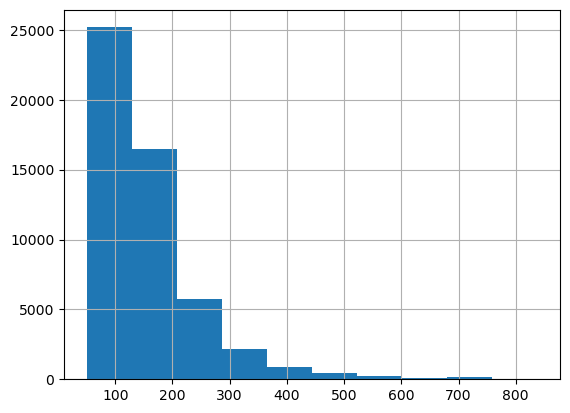

In [25]:
df_test.d_CANTIDAD_PALABRAS[df_test.delitos_seguimiento_comision=="SIN INFORMACION"].hist().plot()

In [26]:
df_test.delitos_seguimiento_comision = df_test.delitos_seguimiento_comision.str.replace('Í', 'I')
df_test.delitos_seguimiento_comision = df_test.delitos_seguimiento_comision.str.replace('Ó', 'O')
df_test.delitos_seguimiento_comision = df_test.delitos_seguimiento_comision.str.strip()

/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [27]:
df_test = df_test[df_test.delitos_seguimiento_comision!="SIN INFORMACION"]

In [28]:
df_test.shape

(462844, 14)

In [29]:
df_test.shape[0]/df.shape[0]*100

63.01432527440212

## Evaluación

Se realiza la evaluación respecto del $63\%$ de datos

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true=df_test.delitos_seguimiento_comision,
                            y_pred=df_test.delitos_seguimiento_predicted))

                                                      precision    recall  f1-score   support

                                    ROBO A DOMICILIO       0.93      0.87      0.90     72499
                                     ROBO A PERSONAS       0.88      0.95      0.91    194640
                          ROBO A UNIDADES ECONOMICAS       0.79      0.77      0.78     30998
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS       0.87      0.87      0.87     68100
                                      ROBO DE CARROS       0.94      0.78      0.85     41823
                                       ROBO DE MOTOS       0.98      0.91      0.94     54784

                                            accuracy                           0.89    462844
                                           macro avg       0.90      0.86      0.88    462844
                                        weighted avg       0.90      0.89      0.89    462844



In [35]:
labels = list(set(df_test.delitos_seguimiento_comision))
cm = confusion_matrix(y_true=df_test.delitos_seguimiento_comision,
                      y_pred=df_test.delitos_seguimiento_predicted,
                      labels=labels)
cm

array([[ 49898,    123,   3492,    292,    408,    571],
       [    36,  23764,   4313,   1705,     43,   1137],
       [   778,   3299, 185558,   1967,    758,   2280],
       [   107,   2125,   5747,  62727,    162,   1631],
       [    86,    110,   5382,    203,  32586,   3456],
       [   127,    642,   6883,    559,    582,  59307]])

In [33]:
62727+5747+2125+1631+162+107

72499

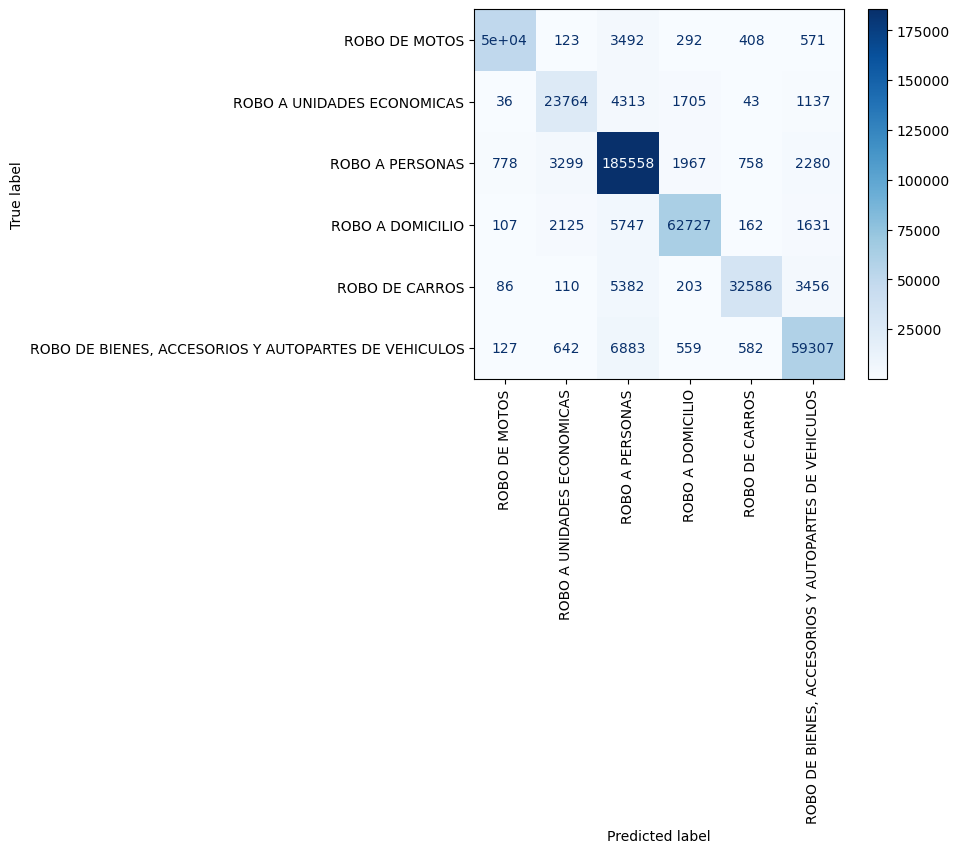

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='vertical')
plt.show()


Normalizando el resultado

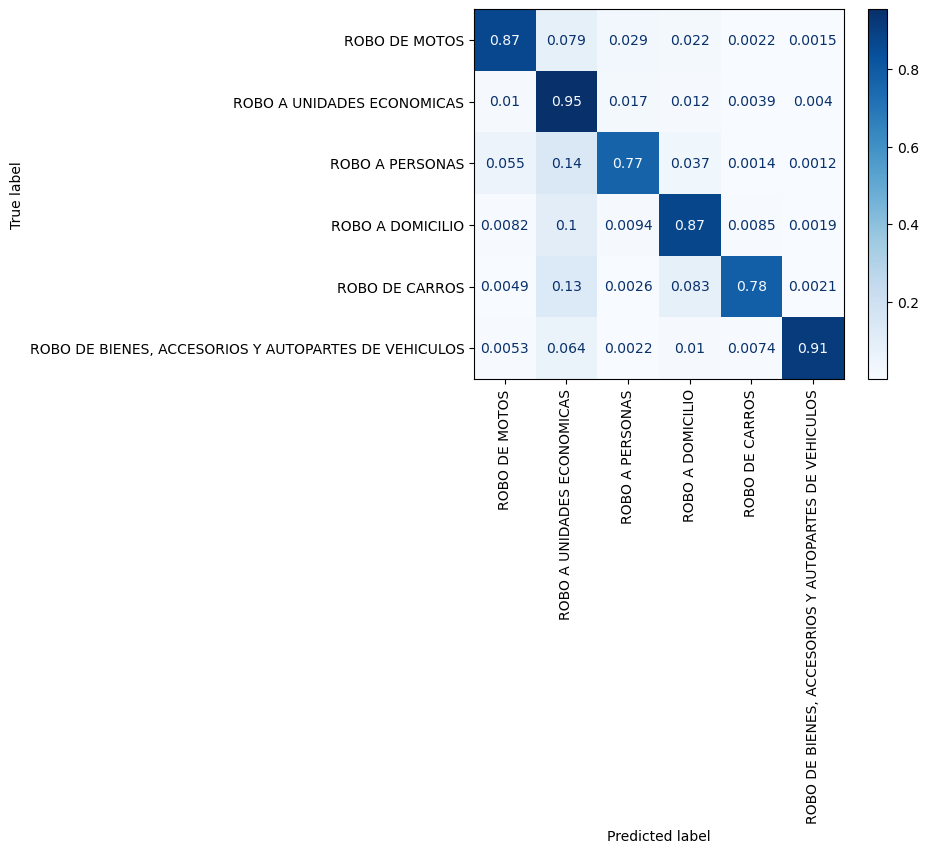

In [38]:
cmn = confusion_matrix(y_true=df_test.delitos_seguimiento_comision, 
                       y_pred=df_test.delitos_seguimiento_predicted,
                       normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cmn, display_labels=labels)
disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='vertical')
plt.show()
